## Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import _LRScheduler
from IPython.display import clear_output

# from models.dvae import DVAE

print('imported')

imported


In [2]:
np.random.seed(42)

DATA_DIR = './data'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

WEIGHTS_DIR = './weights'

IMG_SIZE = (32, 32)
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 200
IN_CHANNELS = 1
LATENT_DIM = 2
NUM_CHANNELS = 128
ENC = '32x1,32d2,16x1,16d2,8x1,8d2,4x1'
# ENC = '32d2,16d2,8d2,4x1'
DEC = '4x1,4u2,8x1,8u2,16x1,16u2,32x1'
# DEC = '4x1,4u2,8u2,16u2'
BOTTLENECK_RATIO = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device: {} ({})'.format(device, torch.cuda.get_device_name(device)))

Current device: cuda (NVIDIA RTX A6000)


## MNIST Data preprocess

In [3]:
# dans un premier lieu, nous allons travailler avec MNIST
mnist = torchvision.datasets.MNIST(root=DATA_DIR, train=True, download=True)

n_samples = 1000

# removing some digits to reduce the size of the dataset
selected_index = np.isin(mnist.targets, [1, 2, 3])
images = mnist.data[selected_index][:n_samples]
targets = mnist.targets[selected_index][:n_samples]

# norm
normalize = lambda x: x / 255.0
denormalize = lambda x: x * 255.0

# preprocessing
images = normalize(images).type(torch.float32)
images = images.unsqueeze(1)

train_x, test_x, train_y, test_y = train_test_split(images, targets, test_size=0.1, random_state=42)

train_loader = torch.utils.data.DataLoader(train_x, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_x, batch_size=BATCH_SIZE, shuffle=False)

class IdentityDataset(torch.utils.data.Dataset):
    def __init__(self, x, transform=None):
        self.transform = transform
        self.x = x

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.x[idx])
        return self.x[idx]

print('Number of training samples: {}'.format(len(train_x)))
print('Number of test samples: {}'.format(len(test_x)))
print('Number of iterations per epoch: {}'.format(len(train_loader)))
print('Image size: {}'.format(train_x.shape))
print('Image max value: {}'.format(train_x.max()))
print('Image min value: {}'.format(train_x.min()))

Number of training samples: 900
Number of test samples: 100
Number of iterations per epoch: 15
Image size: torch.Size([900, 1, 28, 28])
Image max value: 1.0
Image min value: 0.0


### Scheduler

In [4]:
class PolyScheduler(_LRScheduler):
    def __init__(self, optimizer, base_lr, max_steps, warmup_steps, last_epoch=-1):
        self.base_lr = base_lr
        self.warmup_lr_init = LEARNING_RATE / 10
        self.max_steps: int = max_steps
        self.warmup_steps: int = warmup_steps
        self.power = 2
        super(PolyScheduler, self).__init__(optimizer, -1, False)
        self.last_epoch = last_epoch

    def get_warmup_lr(self):
        alpha = float(self.last_epoch) / float(self.warmup_steps)
        return [self.base_lr * alpha for _ in self.optimizer.param_groups]

    def get_lr(self):
        if self.last_epoch == -1:
            return [self.warmup_lr_init for _ in self.optimizer.param_groups]
        if self.last_epoch < self.warmup_steps:
            return self.get_warmup_lr()
        else:
            alpha = pow(
                1
                - float(self.last_epoch - self.warmup_steps)
                / float(self.max_steps - self.warmup_steps),
                self.power,
            )
            return [self.base_lr * alpha for _ in self.optimizer.param_groups]

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def parse_enc_string(s):
    blocks = []
    for block in s.split(','):
        if 'x' in block:
            res, num = block.split('x')
            blocks.extend([(int(res), None) for _ in range(int(num))])
        elif 'd' in block:
            res, down_rate = block.split('d')
            blocks.append((int(res), int(down_rate)))
        elif 'u' in block:
            res, up_rate = block.split('u')
            blocks.append((int(res), int(up_rate)))
    return blocks

class EncodingBlock(nn.Module):
    def __init__(self, res, num_channels, bottleneck_ratio, latent_dim, kernel_size, residual=False, down_rate=None):
        super(EncodingBlock, self).__init__()
        self.residual = residual
        self.down_rate = down_rate
        self.res = res

        # convs
        mid_channels = int(num_channels * bottleneck_ratio)
        self.conv_a = nn.Conv2d(num_channels, mid_channels, kernel_size=1, stride=1, padding=0)
        self.conv_b = nn.Conv2d(mid_channels, mid_channels, kernel_size=kernel_size, stride=1, padding=1)
        self.conv_c = nn.Conv2d(mid_channels, mid_channels, kernel_size=kernel_size, stride=1, padding=1)
        self.conv_d = nn.Conv2d(mid_channels, num_channels, kernel_size=1, stride=1, padding=0)
        self.bn = nn.BatchNorm2d(num_channels)

    def forward(self, x):
        if self.down_rate is not None:
            x = F.avg_pool2d(x, kernel_size=self.down_rate, stride=self.down_rate)
        if self.residual:
            residual = x
        x = F.gelu(self.conv_a(x))
        x = F.gelu(self.conv_b(x))
        x = F.gelu(self.conv_c(x))
        x = self.conv_d(x)
        if self.residual:
            x = x + residual
        x = self.bn(x)
        x = F.gelu(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dim, num_channels, enc_blocks, bottleneck_ratio) -> None:
        super().__init__()
        self.bottleneck_ratio = bottleneck_ratio
        self.enc_blocks = parse_enc_string(enc_blocks)
        self.n_blocks = self.enc_blocks.__len__()

        self.in_conv = nn.Conv2d(in_channels, num_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.encoder = nn.ModuleList([
            EncodingBlock(res, num_channels, bottleneck_ratio, latent_dim, 3, residual=True, down_rate=down_rate) 
            for res, down_rate in self.enc_blocks
        ])

    def forward(self, x, return_activations=False):
        x = self.in_conv(x)
        activations = {}
        for idx, block in enumerate(self.encoder):
            x = block(x)
            activations[(idx, x.shape[2])] = x
        if return_activations:
            return x, activations
        return x

class DecodingBlock(nn.Module):
    def __init__(self, res, num_channels, bottleneck_ratio, latent_dim, kernel_size, residual=False, up_rate=None):
        super(DecodingBlock, self).__init__()
        self.residual = residual
        self.up_rate = up_rate
        self.res = res

        # learnable parameters
        mid_channels = int(num_channels * bottleneck_ratio)
        # self.encoding_layer = nn.Conv2d(num_channels + latent_dim, num_channels, kernel_size=kernel_size, stride=1, padding=1)
        self.conv_a = nn.Conv2d(num_channels, mid_channels, kernel_size=1, stride=1, padding=0)
        self.conv_b = nn.Conv2d(mid_channels, mid_channels, kernel_size=kernel_size, stride=1, padding=1)
        self.conv_c = nn.Conv2d(mid_channels, mid_channels, kernel_size=kernel_size, stride=1, padding=1)
        self.conv_d = nn.Conv2d(mid_channels, num_channels, kernel_size=1, stride=1, padding=0)
        self.bn = nn.BatchNorm2d(num_channels)


    def forward(self, x):
        # x = self.encoding_layer(torch.cat([x, z], dim=1))
        if self.up_rate is not None:
            x = F.interpolate(x, scale_factor=self.up_rate, mode='nearest')
        if self.residual:
            residual = x
        x = F.gelu(self.conv_a(x))
        x = F.gelu(self.conv_b(x))
        x = F.gelu(self.conv_c(x))
        x = self.conv_d(x)
        if self.residual:
            x = x + residual
        x = self.bn(x)
        x = F.gelu(x)
        return x

class Decoder(nn.Module):
    def __init__(self, out_channels, latent_dim, num_channels, dec_blocks, bottleneck_ratio, enc_n_blocks) -> None:
        super().__init__()
        self.bottleneck_ratio = bottleneck_ratio
        self.dec_blocks = parse_enc_string(dec_blocks)
        self.n_blocks = self.dec_blocks.__len__()
        assert enc_n_blocks == self.n_blocks, "Encoder and Decoder must have the same number of blocks"

        self.decoder = nn.ModuleList([
            DecodingBlock(res, num_channels, bottleneck_ratio, latent_dim, 3, residual=True, up_rate=up_rate) 
            for res, up_rate in self.dec_blocks
        ])
        is_3x3_enough = self.dec_blocks[0][0] >= 3
        # self.latent_projection = nn.Conv2d(latent_dim, num_channels, kernel_size=3 if is_3x3_enough else 1, stride=1, padding=1)
        self.latent_projection = nn.Linear(latent_dim, num_channels * self.dec_blocks[0][0] * self.dec_blocks[0][0])
        self.out_conv = nn.Conv2d(num_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, z):
        z = z.view(z.shape[0], -1)
        x = self.latent_projection(z)
        x = x.view(x.shape[0], -1, self.dec_blocks[0][0], self.dec_blocks[0][0])
        for idx, block in enumerate(self.decoder):
            x = block(x)
        x = torch.sigmoid(self.out_conv(x))
        return x

class DVAE(nn.Module):
    def __init__(self, in_channels, out_channels, latent_dim, num_channels, enc_blocks, dec_blocks, bottleneck_ratio, riemannian=True, dt=0.1) -> None:
        super().__init__()
        self.dt = dt
        self.latent_dim = latent_dim
        self.riemannian = riemannian

        self.encoder = Encoder(in_channels, latent_dim, num_channels, enc_blocks, bottleneck_ratio)
        self.decoder = Decoder(out_channels, latent_dim, num_channels, dec_blocks, bottleneck_ratio, self.encoder.n_blocks)

        latent_res = self.decoder.dec_blocks[0][0]
        # self.mu_projection = nn.Conv2d(num_channels, self.latent_dim, kernel_size=latent_res, stride=1, padding=0)
        # self.logvar_projection = nn.Conv2d(num_channels, self.latent_dim, kernel_size=latent_res, stride=1, padding=0)
        self.latent_projection = nn.Conv2d(num_channels, self.latent_dim * 2, kernel_size=latent_res, stride=1, padding=0)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        if self.riemannian:
            return mu + self.hyperboloide_normal_sample(mu, dt=self.dt) * std
        return mu + torch.randn_like(std) * std

    def hyperboloide_normal_sample(self, mu, dt):
        noise = torch.normal(mean=0, std=np.sqrt(dt), size=mu.shape).to(device)
        Y = torch.zeros_like(mu).to(device)
        Y = (mu / 4) * dt + (mu / np.sqrt(2)) * noise
        return Y

    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = self.latent_projection(x).chunk(2, dim=1)
        # mu, logvar = self.mu_projection(x), self.logvar_projection(x)
        z = self.reparametrize(mu, logvar)
        x = self.decoder(z)
        return dict(x=x, z=z, mu=mu, logvar=logvar)

    def loss_function(self, x_hat, x, mu, logvar, beta=1.):
        recon_loss = F.mse_loss(x_hat, x, reduction='none').sum(dim=(1, 2, 3)).mean()
        kl_div = self.kl_divergence(mu, logvar).div(x.shape[0])
        return dict(loss=recon_loss + beta * kl_div, recon_loss=recon_loss, kl_div=kl_div) 

    def kl_divergence(self, mu, logvar):
        return -0.5 * torch.sum(logvar - mu.pow(2) - logvar.exp() + self.dt + np.log(self.dt))

    def sample(self, n_samples, dt=1.):
        features_dim = self.decoder.dec_blocks[0][0]
        z = torch.normal(mean=0, std=np.sqrt(dt), size=(n_samples, self.latent_dim, 1, 1)).to(device)
        if self.riemannian:
            z = self.hyperboloide_normal_sample(z, dt=self.dt)
        x = self.decoder(z)
        return x

## Training

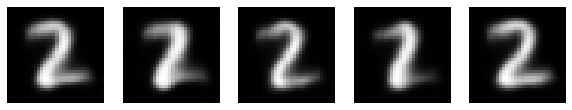

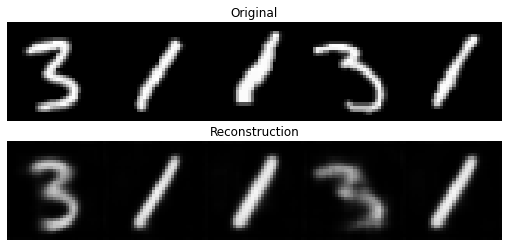

Epoch:    80/200 - Loss: 29.3162 - Recon Loss: 24.6043 - KL Loss: 4.7119: 100%|██████████| 14/14 [00:01<00:00, 12.52it/s]
Epoch:    81/200 - Loss: 29.0338 - Recon Loss: 24.4260 - KL Loss: 4.6079: 100%|██████████| 14/14 [00:00<00:00, 15.34it/s]
Epoch:    82/200 - Loss: 29.3588 - Recon Loss: 24.6430 - KL Loss: 4.7158: 100%|██████████| 14/14 [00:00<00:00, 15.70it/s]
Epoch:    83/200 - Loss: 29.5696 - Recon Loss: 24.8964 - KL Loss: 4.6732: 100%|██████████| 14/14 [00:00<00:00, 15.99it/s]
Epoch:    84/200 - Loss: 29.2437 - Recon Loss: 24.5293 - KL Loss: 4.7144: 100%|██████████| 14/14 [00:00<00:00, 15.41it/s]
Epoch:    85/200 - Loss: 28.6834 - Recon Loss: 23.9919 - KL Loss: 4.6915:  64%|██████▍   | 9/14 [00:00<00:00, 15.30it/s]

KeyboardInterrupt: 

In [11]:
verbose = True

# model
model = DVAE(IN_CHANNELS, IN_CHANNELS, LATENT_DIM, NUM_CHANNELS, ENC, DEC, BOTTLENECK_RATIO, riemannian=True, dt=0.1).to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# data loader
train_loader = torch.utils.data.DataLoader(IdentityDataset(train_x, transform=T.Resize([32, 32])), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# scheduler = PolyScheduler(optimizer, LEARNING_RATE, EPOCHS * len(train_loader), warmup_steps=len(train_loader), last_epoch=-1)

train_loss_history, test_loss_history = [], []

for epoch in range(EPOCHS):
    for phase in ['train']:#, 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = test_loader

        running_loss = 0.0
        running_recon_loss = 0.0
        running_kl_loss = 0.0

        progress = None
        if verbose: progress = tqdm(dataloader, position=0, leave=True)
        for i, (x) in enumerate(dataloader):
            x = x.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                output = model(x)
                stats = model.loss_function(output['x'], x, output['mu'], output['logvar'])
                if phase == 'train':
                    stats['loss'].backward()
                    # torch.nn.utils.clip_grad_norm_(model.parameters(), 4)
                    optimizer.step()
                    # scheduler.step()

            running_loss += stats['loss'].item()
            running_recon_loss += stats['recon_loss'].item()
            running_kl_loss += stats['kl_div'].item()

            if verbose:
                with torch.no_grad():
                    progress.update(1)
                    progress.set_description('Epoch: {:5}/{} - Loss: {:.4f} - Recon Loss: {:.4f} - KL Loss: {:.4f}'.format(
                        epoch + 1, EPOCHS, running_loss / (i + 1), running_recon_loss / (i + 1), running_kl_loss / (i + 1)
                    ))

        epoch_loss = running_loss / dataloader.__len__()
        if phase == 'train':
            train_loss_history.append(epoch_loss)
        else:
            test_loss_history.append(epoch_loss)

        if (epoch + 1) % 10 == 0:
            # cleaning output
            clear_output(wait=True)
            
            # plotting generation
            model.eval()
            n_sample = 5
            sample = model.sample(n_sample, dt=1)
            sample = denormalize(sample).type(torch.uint8)
            plt.figure(figsize=(10, 2))
            for i in range(n_sample):
                plt.subplot(1, n_sample, i + 1)
                plt.axis('off')
                plt.imshow(sample[i].squeeze(0).detach().cpu(), cmap='gray')
            plt.show()

            # plotting reconstruction
            x = torch.hstack([img for img in x[:n_sample].view(n_sample, 32, 32)])
            x = denormalize(x).type(torch.uint8)
            x_hat = torch.hstack([img for img in output['x'][:n_sample].view(n_sample, 32, 32)])
            x_hat = denormalize(x_hat).type(torch.uint8)
            plt.figure(figsize=(20, 4))
            plt.subplot(2, 1, 1)
            plt.axis('off')
            plt.title('Original')
            plt.imshow(torchvision.utils.make_grid(x, nrow=n_sample).detach().cpu().permute(1, 2, 0), cmap='gray')
            plt.subplot(2, 1, 2)
            plt.axis('off')
            plt.title('Reconstruction')
            plt.imshow(torchvision.utils.make_grid(x_hat, nrow=n_sample).detach().cpu().permute(1, 2, 0), cmap='gray')
            plt.show()

        if verbose: progress.close()
        del progress

print('Training over')

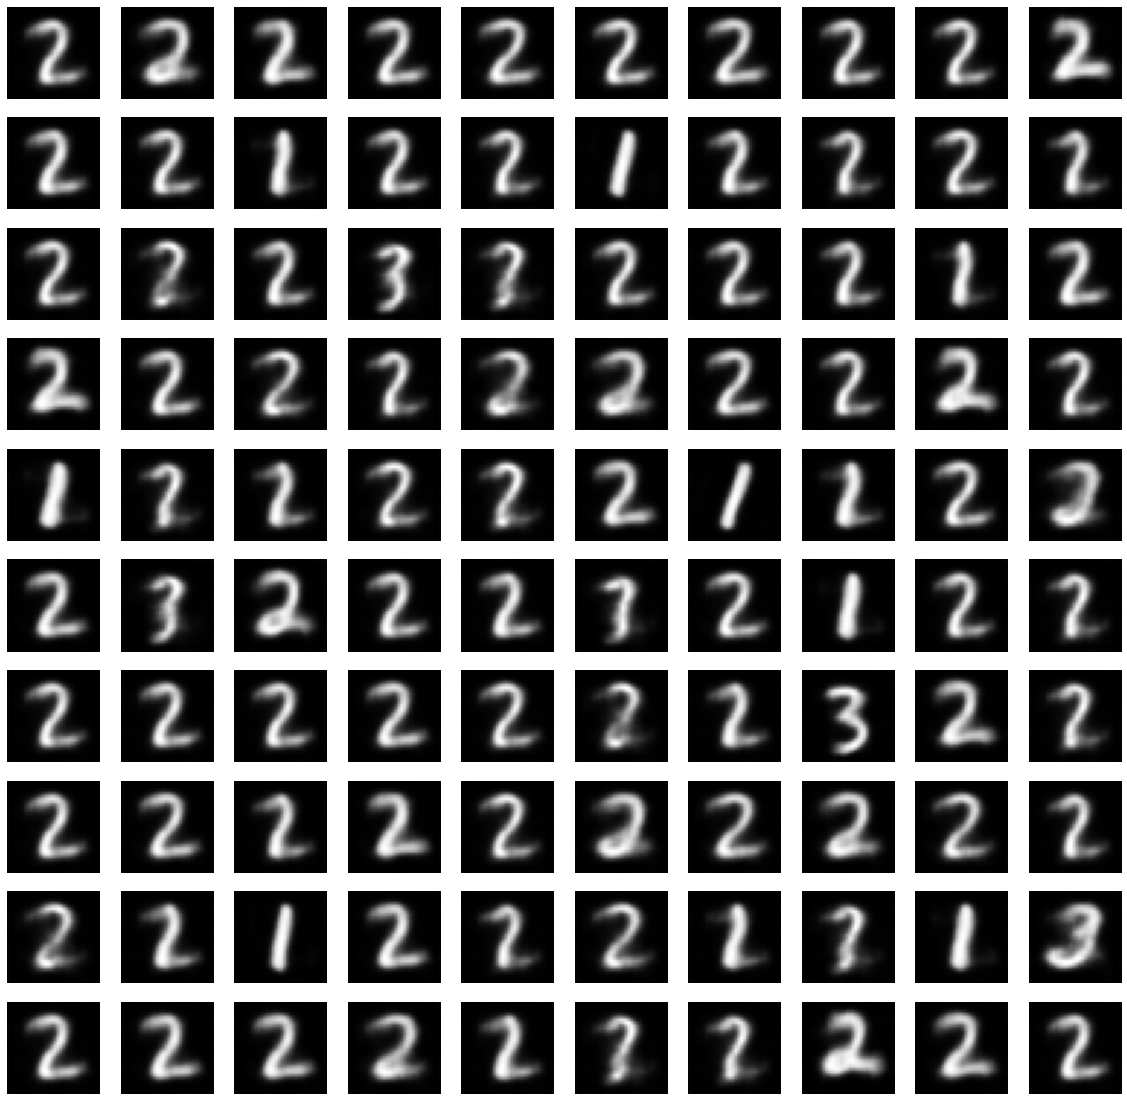

In [12]:
model.eval()
recons = model.sample(100, 1)
recons = recons.cpu().detach().numpy().reshape(100, *IMG_SIZE)

plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(recons[i], cmap='gray')
    plt.axis('off')
plt.show()

In [13]:
import torchvision.transforms as T
train_x = T.functional.resize(train_x, (32, 32))
output = model.forward(train_x.to(device))

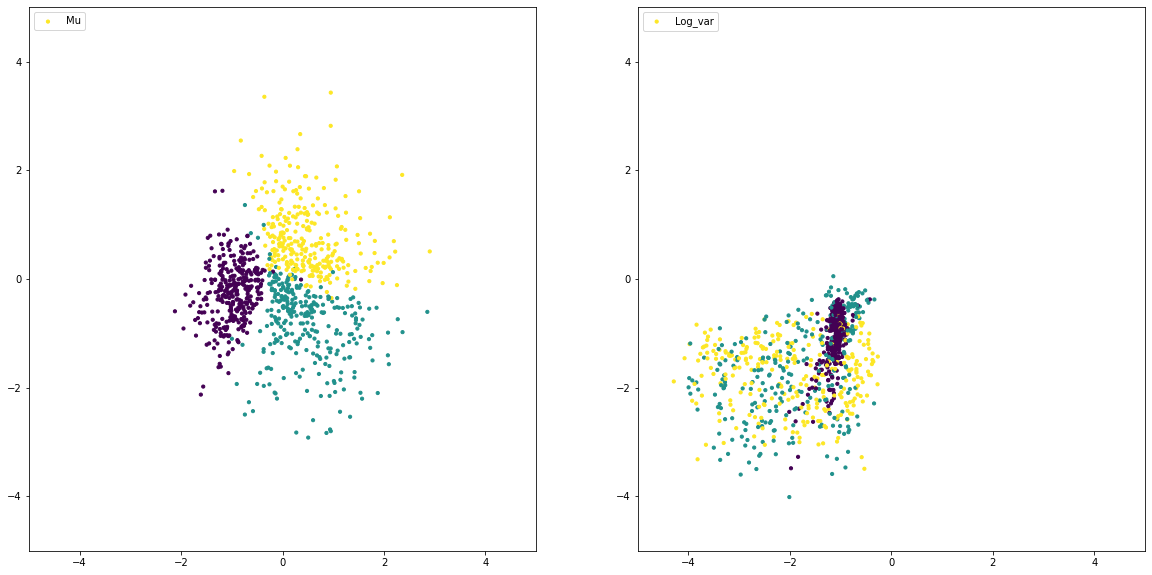

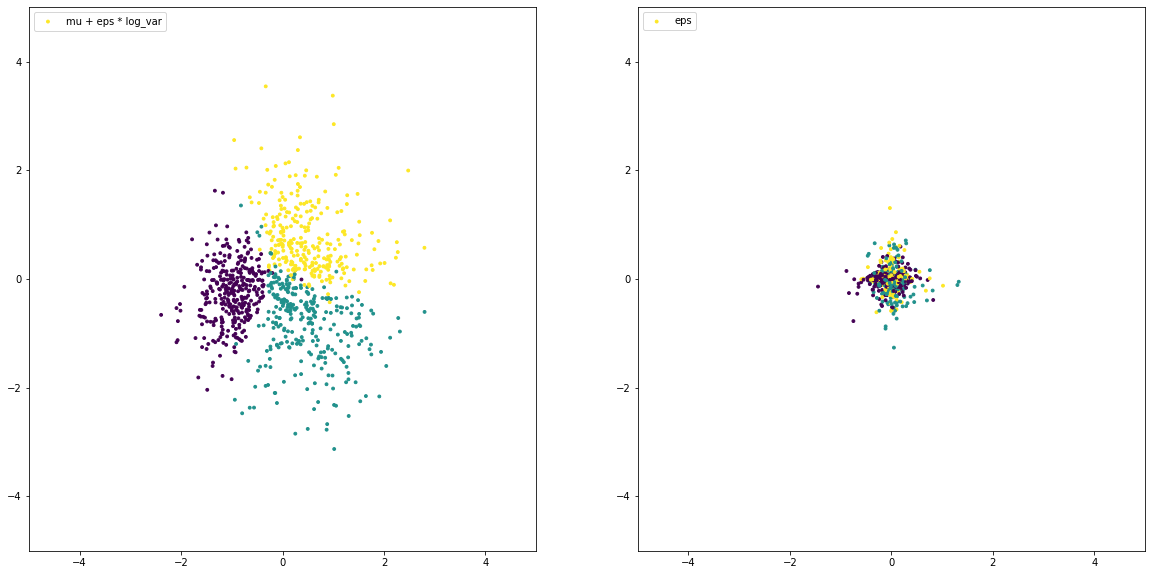

Epoch:    85/200 - Loss: 28.6834 - Recon Loss: 23.9919 - KL Loss: 4.6915:  64%|██████▍   | 9/14 [00:15<00:00, 15.30it/s]

In [14]:
_, mu, log_var, z_space = output['x'], output['mu'], output['logvar'], output['z'].reshape(-1, 2)
if model.riemannian:
    eps = model.hyperboloide_normal_sample(mu, model.dt)
else:    
    eps = torch.normal(mean=0, std=1, size=mu.shape).to(device)

plt.figure(figsize=(20, 10))
for i, (var, name) in enumerate(zip([mu, log_var], ['Mu', 'Log_var'])):
    plt.subplot(1, 2, i + 1)
    plt.scatter(var[:, 0].detach().cpu().numpy(), var[:, 1].detach().cpu().numpy(), s=10, label=name, c=train_y)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.legend(loc="upper left")
plt.show()

plt.figure(figsize=(20, 10))
for i, (var, name) in enumerate(zip([z_space, eps], ['mu + eps * log_var', 'eps'])):
    plt.subplot(1, 2, i + 1)
    plt.scatter(var[:, 0].detach().cpu().numpy(), var[:, 1].detach().cpu().numpy(), s=8, label=name, c=('b' if name == 'Y' else train_y))
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.legend(loc="upper left")
plt.show()
